# CompMech04-Linear Algebra Project
## Practical Linear Algebra for Finite Element Analysis

In this project we will perform a linear-elastic finite element analysis (FEA) on a support structure made of 11 beams that are riveted in 7 locations to create a truss as shown in the image below. 

![Mesh image of truss](../images/mesh.png)

The triangular truss shown above can be modeled using a [direct
stiffness method
[1]](https://en.wikipedia.org/wiki/Direct_stiffness_method), that is
detailed in the [extra-FEA_material](./extra-FEA_material.md) notebook.
The end result of converting this structure to a FE model. Is that each
joint, labeled $n~1-7$, short for _node 1-7_ can move in the x- and
y-directions, but causes a force modeled with Hooke's law. Each beam
labeled $el~1-11$, short for _element 1-11_, contributes to the
stiffness of the structure. We have 14 equations where the sum of the
components of forces = 0, represented by the equation

$\mathbf{F-Ku}=\mathbf{0}$

Where, $\mathbf{F}$ are externally applied forces, $\mathbf{u}$ are x- and y- displacements of nodes, and $\mathbf{K}$ is the stiffness matrix given in `fea_arrays.npz` as `K`, shown below

_note: the array shown is 1000x(`K`). You can use units of MPa (N/mm^2), N, and mm. The array `K` is in 1/mm_

$\mathbf{K}=EA*$

$  \left[ \begin{array}{cccccccccccccc}
 4.2 & 1.4 & -0.8 & -1.4 & -3.3 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 1.4 & 2.5 & -1.4 & -2.5 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 -0.8 & -1.4 & 5.0 & 0.0 & -0.8 & 1.4 & -3.3 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 -1.4 & -2.5 & 0.0 & 5.0 & 1.4 & -2.5 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 -3.3 & 0.0 & -0.8 & 1.4 & 8.3 & 0.0 & -0.8 & -1.4 & -3.3 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 0.0 & 0.0 & 1.4 & -2.5 & 0.0 & 5.0 & -1.4 & -2.5 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
 0.0 & 0.0 & -3.3 & 0.0 & -0.8 & -1.4 & 8.3 & 0.0 & -0.8 & 1.4 & -3.3 & 0.0 & 0.0 & 0.0 \\
 0.0 & 0.0 & 0.0 & 0.0 & -1.4 & -2.5 & 0.0 & 5.0 & 1.4 & -2.5 & 0.0 & 0.0 & 0.0 & 0.0 \\
 0.0 & 0.0 & 0.0 & 0.0 & -3.3 & 0.0 & -0.8 & 1.4 & 8.3 & 0.0 & -0.8 & -1.4 & -3.3 & 0.0 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.4 & -2.5 & 0.0 & 5.0 & -1.4 & -2.5 & 0.0 & 0.0 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -3.3 & 0.0 & -0.8 & -1.4 & 5.0 & 0.0 & -0.8 & 1.4 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -1.4 & -2.5 & 0.0 & 5.0 & 1.4 & -2.5 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & -3.3 & 0.0 & -0.8 & 1.4 & 4.2 & -1.4 \\
 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 1.4 & -2.5 & -1.4 & 2.5 \\
\end{array}\right]~\frac{1}{m}$

In [1]:
import numpy as np
#from scipy.linalg import lu
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
fea_arrays = np.load('./fea_arrays.npz')
K=fea_arrays['K']
nodes = fea_arrays['nodes']
elems = fea_arrays['elems']

In this project we are solving the problem, $\mathbf{F}=\mathbf{Ku}$, where $\mathbf{F}$ is measured in Newtons, $\mathbf{K}$ `=E*A*K` is the stiffness in N/mm, `E` is Young's modulus measured in MPa (N/mm^2), and `A` is the cross-sectional area of the beam measured in mm^2. 

There are three constraints on the motion of the joints:

i. node 1 displacement in the x-direction is 0 = `u[0]`

ii. node 1 displacement in the y-direction is 0 = `u[1]`

iii. node 7 displacement in the y-direction is 0 = `u[13]`

We can satisfy these constraints by leaving out the first, second, and last rows and columns from our linear algebra description.

### 1. Calculate the condition of `K` and the condition of `K[2:13,2:13]`. 

a. What error would you expect when you solve for `u` in `K*u = F`? 

b. Why is the condition of `K` so large? 

c. What error would you expect when you solve for `u[2:13]` in `K[2:13,2:13]*u=F[2:13]`

In [3]:
print('{:e}'.format(np.linalg.cond(K)))
print('{:e}'.format(np.linalg.cond(K[2:13, 2:13])))

1.457753e+17
5.223543e+01


**a. I would expect that K is an ill-conditioned matrix. No error would pop up but the data would be so sensitive to small changes that the answer I would get when solving K*u = F would not be accurate**.

**b. The condition is so large because K is comprised of small numbers to begin with. It will be more sensitive to floating point number round-off error and mess up the entire iterative process of the np.linal.solve() function**

**c. For this case, the error that would pop up would probably be that the matrix is singular. Even though the condition is small enough - 52 is not ideal but good enough I suppose - there would be infinitely many solutions to the problem.**

### 2. Apply a 300-N downward force to the central top node (n 4)

a. Create the LU matrix for K[2:13,2:13]

b. Use cross-sectional area of $0.1~mm^2$ and steel and almuminum moduli, $E=200~GPa~and~E=70~GPa,$ respectively. Solve the forward and backward substitution methods for 

* $\mathbf{Ly}=\mathbf{F}\frac{1}{EA}$

* $\mathbf{Uu}=\mathbf{y}$

_your array `F` is zeros, except for `F[5]=-300`, to create a -300 N load at node 4._

c. Plug in the values for $\mathbf{u}$ into the full equation, $\mathbf{Ku}=\mathbf{F}$, to solve for the reaction forces

d. Create a plot of the undeformed and deformed structure with the
displacements and forces plotted as vectors (via `quiver`). Your result
for aluminum (**typo: should be steel**) should match the following result from
[extra-FEA_material](./extra-FEA_material.md). _note: The scale factor is applied to displacements $\mathbf{u}$, not forces._

> __Note__: Look at the [extra FEA material](./extra-FEA_material). It
> has example code that you can plug in here to make these plots.
> Including background information and the source code for this plot
> below.


![Deformed structure with loads applied](../images/deformed_truss.png)

In [4]:
#From Lecture Readings
def LUNaive(A):
    '''LUNaive: naive LU decomposition
    L,U = LUNaive(A): LU decomposition without pivoting.
    solution method requires floating point numbers, 
    as such the dtype is changed to float
    
    Arguments:
    ----------
    A = coefficient matrix
    returns:
    ---------
    L = Lower triangular matrix
    U = Upper triangular matrix
    '''
    [m,n] = np.shape(A)
    if m!=n: error('Matrix A must be square')
    nb = n+1
    # Gauss Elimination
    U = A.astype(float)
    L = np.eye(n)

    for k in range(0,n-1):
        for i in range(k+1,n):
            if U[k,k] != 0.0:
                factor = U[i,k]/U[k,k]
                L[i,k]=factor
                U[i,:] = U[i,:] - factor*U[k,:]
    return L,U

##############################################################################

def solveLU(L,U,b):
    '''solveLU: solve for x when LUx = b
    x = solveLU(L,U,b): solves for x given the lower and upper 
    triangular matrix storage
    uses forward substitution for 
    1. Ly = b
    then backward substitution for
    2. Ux = y
    
    Arguments:
    ----------
    L = Lower triangular matrix
    U = Upper triangular matrix
    b = output vector
    
    returns:
    ---------
    x = solution of LUx=b '''
    n=len(b)
    x=np.zeros(n)
    y=np.zeros(n)
        
    # forward substitution
    for k in range(0,n):
        y[k] = b[k] - L[k,0:k]@y[0:k]
    # backward substitution
    for k in range(n-1,-1,-1):
        x[k] = (y[k] - U[k,k+1:n]@x[k+1:n])/U[k,k]
    return x

In [5]:
#P,L,U = lu(K[2:13, 2:13])
L,U = LUNaive(K[2:13, 2:13])
F=np.zeros(2*len(nodes)-3)
F[5]=-300

E_st = 200e3 #MPa
E_al = 70e3  #MPa
A = 0.1      #mm^2

#Calculate free nodes (unconstrained)
uf_st = solveLU(L,U,F/(E_st*A))
uf_al = solveLU(L,U,F/(E_al*A))

#add solutions to full system
u_st=np.zeros(2*len(nodes))
u_st[2:13]=uf_st
u_al=np.zeros(2*len(nodes))
u_al[2:13]=uf_al

#plug into full equation
F_st = E_st*A*K@u_st
F_al = E_al*A*K@u_al

xy={0:'x',1:'y'}
print('Forces of steel truss:\n----------------')
for i in range(len(F_st)):
    print('F_{}{}:{:.2f} N'.format(int(i/2)+1,xy[i%2],F_st[i]))
print('\nForces of aluminum truss:\n----------------')
for i in range(len(F_al)):
    print('F_{}{}:{:.2f} N'.format(int(i/2)+1,xy[i%2],F_al[i]))

Forces of steel truss:
----------------
F_1x:-0.00 N
F_1y:150.00 N
F_2x:0.00 N
F_2y:-0.00 N
F_3x:-0.00 N
F_3y:0.00 N
F_4x:-0.00 N
F_4y:-300.00 N
F_5x:-0.00 N
F_5y:-0.00 N
F_6x:-0.00 N
F_6y:-0.00 N
F_7x:0.00 N
F_7y:150.00 N

Forces of aluminum truss:
----------------
F_1x:-0.00 N
F_1y:150.00 N
F_2x:0.00 N
F_2y:0.00 N
F_3x:0.00 N
F_3y:-0.00 N
F_4x:-0.00 N
F_4y:-300.00 N
F_5x:0.00 N
F_5y:-0.00 N
F_6x:-0.00 N
F_6y:-0.00 N
F_7x:0.00 N
F_7y:150.00 N


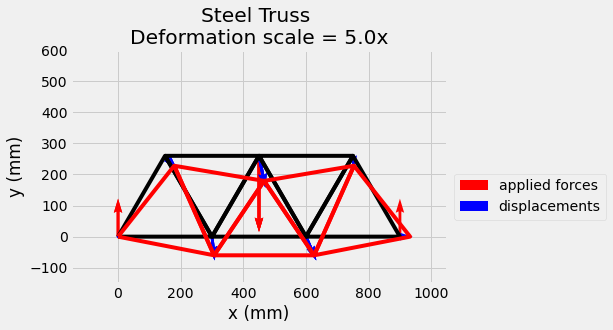

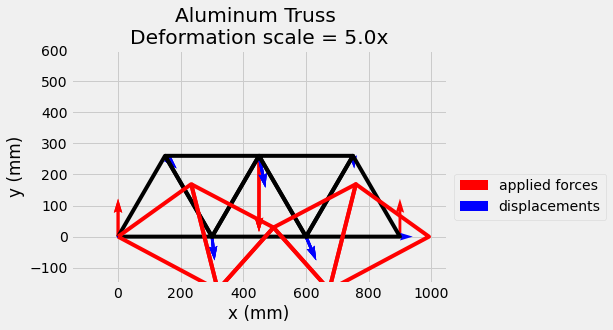

In [6]:
ix = 2*np.block([[np.arange(0,5)],
                 [np.arange(1,6)],
                 [np.arange(2,7)],
                 [np.arange(0,5)]])
iy = ix+1
r = np.block([n[1:3] for n in nodes])

plt.plot(r[ix],r[iy],'-',color=(0,0,0,1))
plt.plot(r[ix]+u_st[ix]*5,r[iy]+u_st[iy]*5,'-',color=(1,0,0,1))
plt.quiver(r[ix],r[iy],F_st[ix],F_st[iy],color=(1,0,0,1),label='applied forces')
plt.quiver(r[ix],r[iy],u_st[ix],u_st[iy],color=(0,0,1,1),label='displacements')
plt.axis(300*np.array([-0.5,3.5,-0.5,2]))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Steel Truss \nDeformation scale = {:.1f}x'.format(5))
plt.legend(bbox_to_anchor=(1,0.5))
plt.show()

plt.plot(r[ix],r[iy],'-',color=(0,0,0,1))
plt.plot(r[ix]+u_al[ix]*5,r[iy]+u_al[iy]*5,'-',color=(1,0,0,1))
plt.quiver(r[ix],r[iy],F_al[ix],F_al[iy],color=(1,0,0,1),label='applied forces')
plt.quiver(r[ix],r[iy],u_al[ix],u_al[iy],color=(0,0,1,1),label='displacements')
plt.axis(300*np.array([-0.5,3.5,-0.5,2]))
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('Aluminum Truss \nDeformation scale = {:.1f}x'.format(5))
plt.legend(bbox_to_anchor=(1,0.5))
plt.show()

### 3. Determine cross-sectional area

a. Using aluminum, what is the minimum cross-sectional area to keep total y-deflections $<0.2~mm$?

b. Using steel, what is the minimum cross-sectional area to keep total y-deflections $<0.2~mm$?

c. What are the weights of the aluminum and steel trusses with the
chosen cross-sectional areas?

In [7]:
def trussDisp(L,U,A,Force=300):
    F=np.zeros(2*len(nodes)-3)
    F[5]=-Force
    
    E_st = 200e3 #MPa
    E_al = 70e3  #MPa 

    #Calculate free nodes (unconstrained)
    uf_st = solveLU(L,U,F/(E_st*A))
    uf_al = solveLU(L,U,F/(E_al*A))

    #add solutions to full system for total displacement
    u_st=np.zeros(2*len(nodes))
    u_st[2:13]=uf_st
    u_al=np.zeros(2*len(nodes))
    u_al[2:13]=uf_al
    
    #add up all the displacements
    sigma_st = abs(sum(u_st[1::2]))
    sigma_al = abs(sum(u_al[1::2]))
    
    return sigma_st, sigma_al

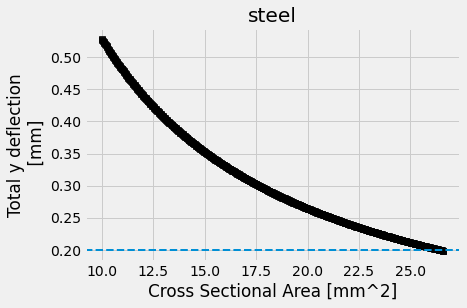

steel: total y deflection is 0.199 mm for cross sectional area of 26.6 mm^2


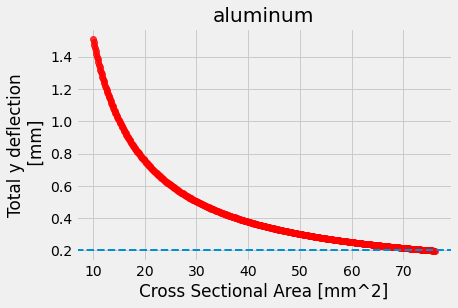

aluminum: total y deflection is 0.199 mm for cross sectional area of 76.0 mm^2


In [10]:
A_st = np.linspace(10,26.6,500)
A_al = np.linspace(10,76,500)

disp_st = np.zeros(len(A_st))
disp_al = np.zeros(len(A_al))

for i in range(len(A_st)):
    disp_st[i] = trussDisp(L,U,A_st[i])[0]

for i in range(len(A_al)):
    disp_al[i] = trussDisp(L,U,A_al[i])[1]

plt.plot(A_st, disp_st, 'ks', alpha=0.75)
plt.axhline(0.2, ls='--', lw=2)
plt.xlabel('Cross Sectional Area [mm^2]')
plt.ylabel('Total y deflection\n [mm]')
plt.title('steel')
plt.show()
print('steel: total y deflection is {:.3f} mm for cross sectional area of {} mm^2'.format(disp_st[-1], A_st[-1]))

plt.plot(A_al, disp_al, 'ro', alpha=0.75)
plt.axhline(0.2, ls='--', lw=2)
plt.xlabel('Cross Sectional Area [mm^2]')
plt.ylabel('Total y deflection\n [mm]')
plt.title('aluminum')
plt.show()
print('aluminum: total y deflection is {:.3f} mm for cross sectional area of {} mm^2'.format(disp_al[-1], A_al[-1]))

In [11]:
#density of material
rho_st = 7.85e-6  #kg/mm^3
rho_al = 2.7e-6  #kg/mm^3

#desired cross sectional areas
a_st = A_st[-1]  #mm^2
a_al = A_al[-1]  #mm^2

#length of each beam
l = 300  #mm

#number of beams
num = 11

#total mass (mass of each beam * number of beams)
m_st = (rho_st * l * a_st) * num
m_al = (rho_al * l * a_al) * num

print('total mass of steel truss is {:.3f} kg making the total weight {:.2f} N'.format(m_st, m_st*9.81))
print('total mass of aluminum truss is {:.3f} kg making the total weight {:.2f} N'.format(m_al, m_al*9.81))

total mass of steel truss is 0.689 kg making the total weight 6.76 N
total mass of aluminum truss is 0.677 kg making the total weight 6.64 N


## References

1. <https://en.wikipedia.org/wiki/Direct_stiffness_method>